In [1]:
!pip install tick

from collections import defaultdict
import pandas as pd
import numpy as np
import numpy.random as npr
from numpy.linalg import norm
from datetime import datetime
from math import sqrt
from tick.hawkes import SimuHawkes, HawkesKernelExp

import stop_detection as sd

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib import cm

### Function definitions for trajectory simulation and sampling

In [2]:
# Define stay centers and radii
mu_0 = np.array([-100,110])
mu_1 = np.array([0,-110])
mu_2 = np.array([950,0])

r_0 = 30
r_1 = 30
r_2 = 60

# Define normal distributions for stays
sig_1 = 30
sig_2 = 60
eps = 8

var_1 = np.identity(2)*(sig_1 + eps)**2
var_2 = np.identity(2)*(sig_2 + eps)**2
var_3 = np.identity(2)*eps**2

# Means of stays
def mu_t(t):
    '''
    Stay:0 spans [0, 1]
    Stay:1 spans [1.085, 2.085]
    Stay:2 spans [2.34, 5.34]
    '''
    #expects input between 0 and 5.34
    if t>=0 and t<1:
        r = sig_1*np.array([np.sin(t*2*np.pi - np.pi/4),np.cos(t*2*np.pi - np.pi/4)])
        return(mu_0+r)
    elif t>=1 and t<1.085:
        return((mu_1-mu_0)*(t-1)/0.085+mu_0)
    elif t>=1.085 and t<2.085:
        r = sig_1*np.array([np.sin((t-1.085)*2*np.pi + np.pi/2),np.cos((t-1.085)*2*np.pi + np.pi/2)])
        return(mu_1+r)
    elif t>=2.085 and t<2.34:
        return((mu_2-mu_1)*(t-2.085)/0.255+mu_1)
    else:
        r = sig_2*np.array([np.sin((t-2.34)*2*np.pi/3+np.pi),np.cos((t-2.34)*2*np.pi/3+np.pi)])
        return(mu_2)
    
# Variances of stays
def var_t(t):
    if t>=0 and t<1:
        return(var_1)
    elif t>=1 and t<1.085:
        return(var_3)
    elif t>=1.085 and t<2.085:
        return(var_1)
    elif t>=2.085 and t<2.34:
        return(var_3)
    else:
        return(var_2)    
    
# Uniformly samples timestamps, then sample coordinates for these timestamps
# from a normal distribution parameterized by the mean and variance of the timestamp
def simulate_traj(freq, seed=None):
    '''
    freq: how many pings to sample per hour
    '''
    
    if seed:
        npr.seed(seed)
    else:
        seed = npr.randint(0,1000,1)[0]
        npr.seed(seed)
        print(seed)
    
    #Sample Points
    times = sorted(npr.uniform(0, 5.5, np.ceil(freq*5.5).astype(int)))
    mu = [mu_t(t) for t in times]
    var = [var_t(t) for t in times]
    pings = np.array([np.random.multivariate_normal(m,v, 1)[0] for m,v in zip(mu, var)])
    
    #Create trajectory dataframe
    df = pd.DataFrame(pings, columns = ['x', 'y'])
    df['local_timestamp'] = pd.to_datetime([datetime(2022, 1, 1, int(t), int((t*60) % 60)).isoformat() for t in times])
    df['identifier'] = 'User X'
    df = df.drop_duplicates('local_timestamp')
    df['unix_timestamp'] = (df['local_timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    return df 

### Function definitions for DBScan

### Plot Trajectory Simulation

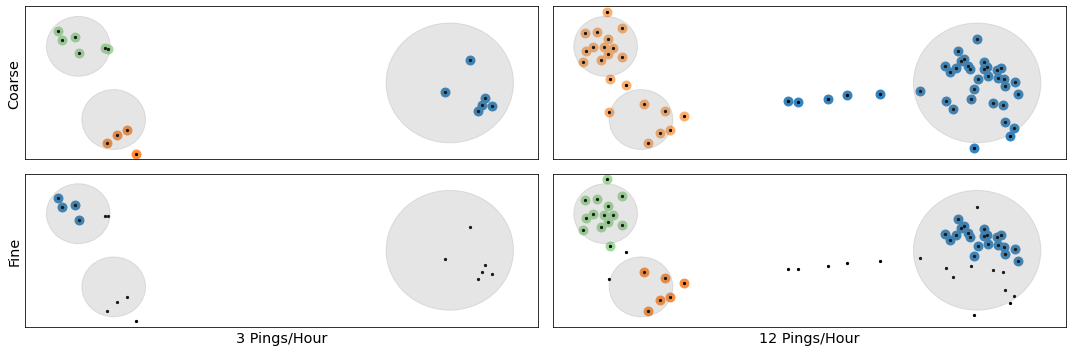

In [3]:
%matplotlib inline

fig, axes = plt.subplots(2,2, figsize=(15, 5))

# Sampling frequencies: coarse=3pings/hr, fine=12pings/hr
freq = [3, 12]

# DBScan parameterizations: resp. coarse and fine
params = [(120, 120, 2), (60, 75, 3)]

const = 3

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        seed = [520, 110][j]
        df = simulate_traj(freq[j], seed=seed)
        df = df.set_index('unix_timestamp', drop=False)

        dbscan_df = sd.temporal_dbscan(df, *params[i])

        patches = [Circle(mu_0/const, r_0, color='gray', alpha=0.2),
                   Circle(mu_1/const, r_1, color='gray', alpha=0.2),
                   Circle(mu_2/const, r_2, color='gray', alpha=0.2)]
        for p in patches:
            ax.add_patch(p)

        num_clusters = sum(dbscan_df.cluster.unique() > -1)

        for cid in range(num_clusters):
            cpings = dbscan_df[dbscan_df.cluster == cid]
            cdata = df.loc[cpings.index]
            col = cm.tab20c(cid/(num_clusters+1))
            ax.scatter(cdata.x/const, cdata.y/const, s=80, color=col, alpha=1, zorder=1)        

        ax.scatter(df.x/const, df.y/const, s=5, color='black', alpha=1)
    
        ax.set_xlim((-250/const,1200/const))
        ax.set_ylim((-230/const, 230/const))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    
axes[0,0].set_ylabel('Coarse', fontsize='x-large')
axes[1,0].set_ylabel('Fine', fontsize='x-large')
axes[1,0].set_xlabel('3 Pings/Hour', fontsize='x-large')
axes[1,1].set_xlabel('12 Pings/Hour', fontsize='x-large')

plt.tight_layout()
plt.savefig("stdbscan.png")
plt.show()